# Comparing SARIMA Models for FC Barcelona and Real Madrid

In this notebook, we will build SARIMA models for both FC Barcelona and Real Madrid based on their La Liga points from the past 10 seasons. We'll compare the forecast results to see which team is predicted to perform better in future seasons.

### Step 1: Load the Data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the datasets
barca_df = pd.read_csv('fc_barcelona_laliga_points.csv', index_col='Season', parse_dates=True)
real_madrid_df = pd.read_csv('real_madrid_laliga_points.csv', index_col='Season', parse_dates=True)

barca_df.head(), real_madrid_df.head()

(            Points
 Season            
 2023-01-01      88
 2022-01-01      73
 2021-01-01      79
 2020-01-01      82
 2019-01-01      87,
             Points
 Season            
 2023-01-01      78
 2022-01-01      86
 2021-01-01      84
 2020-01-01      87
 2019-01-01      68)

### Step 2: Check for Stationarity

In [10]:
# Function to check stationarity
def check_stationarity(df):
    result = adfuller(df['Points'])
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        df_diff = df['Points'].diff().dropna()
    else:
        df_diff = df['Points']
    return df_diff

barca_diff = check_stationarity(barca_df)
real_madrid_diff = check_stationarity(real_madrid_df)

ADF Statistic: -1.331638185492843
p-value: 0.6145764161402067
ADF Statistic: -0.22736575783330035
p-value: 0.9351801058686151


### Step 3: Plot ACF and PACF

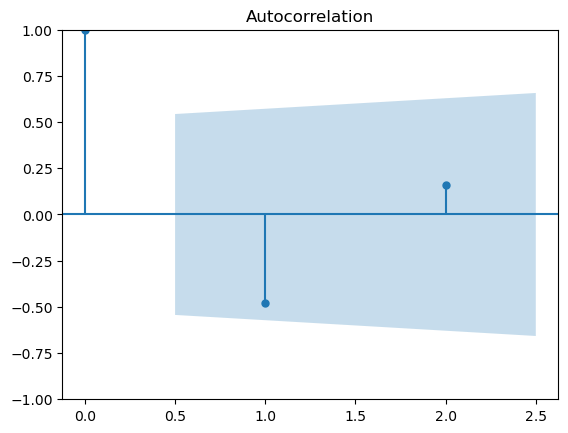

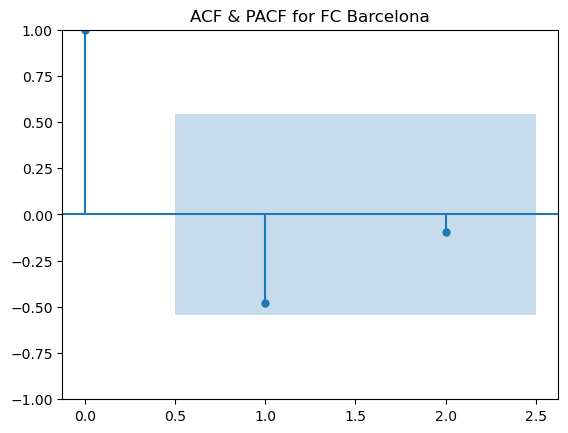

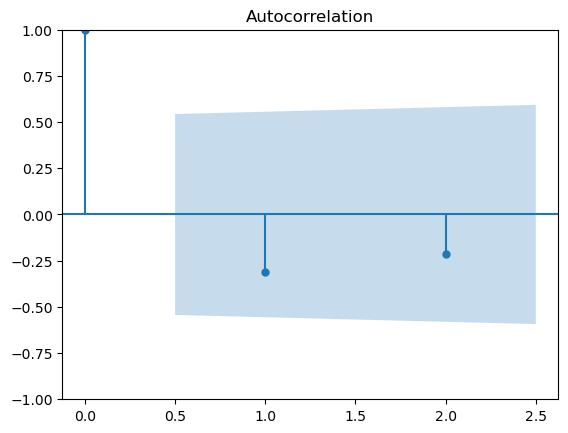

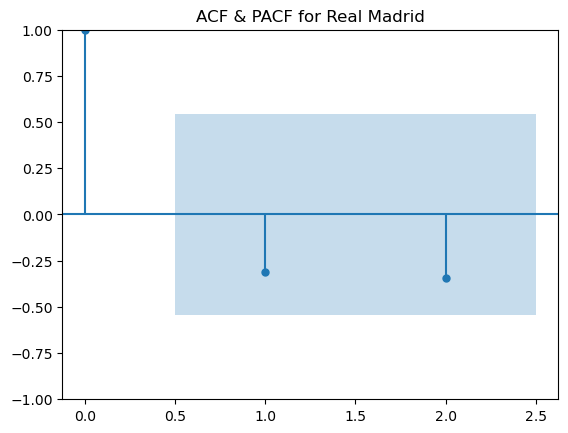

In [13]:
def plot_acf_pacf(df_diff, title):
    # Set lags to be smaller to avoid exceeding the limit
    lags = min(2, len(df_diff) // 2 - 1)  # Use 2 lags or less if data is too small
    
    plot_acf(df_diff, lags=lags)
    plot_pacf(df_diff, lags=lags)
    plt.title(f'ACF & PACF for {title}')
    plt.show()

plot_acf_pacf(barca_diff, "FC Barcelona")
plot_acf_pacf(real_madrid_diff, "Real Madrid")


### Step 4: Fit SARIMA Models

In [16]:
# Ensure date index is sorted
barca_df = barca_df.sort_index()
real_madrid_df = real_madrid_df.sort_index()

# Set the frequency explicitly
barca_df.index = pd.to_datetime(barca_df.index, format='%Y')
real_madrid_df.index = pd.to_datetime(real_madrid_df.index, format='%Y')

barca_df.index.freq = 'AS-JAN'
real_madrid_df.index.freq = 'AS-JAN'


In [18]:
# Sort index and set frequency
barca_df = barca_df.sort_index()
real_madrid_df = real_madrid_df.sort_index()

barca_df.index = pd.to_datetime(barca_df.index, format='%Y')
real_madrid_df.index = pd.to_datetime(real_madrid_df.index, format='%Y')

barca_df.index.freq = 'AS-JAN'
real_madrid_df.index.freq = 'AS-JAN'

def fit_sarima(df, order, seasonal_order, team_name):
    model = SARIMAX(df['Points'], 
                    order=order, 
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    results = model.fit()
    
    print(f"SARIMA Model Summary for {team_name}:\n")
    print(results.summary())
    return results

barca_model = fit_sarima(barca_df, (1, 1, 1), (0, 0, 0, 0), "FC Barcelona")
real_madrid_model = fit_sarima(real_madrid_df, (1, 1, 1), (0, 0, 0, 0), "Real Madrid")

SARIMA Model Summary for FC Barcelona:

                               SARIMAX Results                                
Dep. Variable:                 Points   No. Observations:                   14
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -35.647
Date:                Sun, 11 Aug 2024   AIC                             77.294
Time:                        23:59:19   BIC                             78.488
Sample:                    01-01-2010   HQIC                            76.542
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6589      0.695     -0.948      0.343      -2.021       0.704
ma.L1         -0.0799      0.565     -0.141      0.888      -1.186       1.027
sigma2      

### Step 5: Forecast Future Points

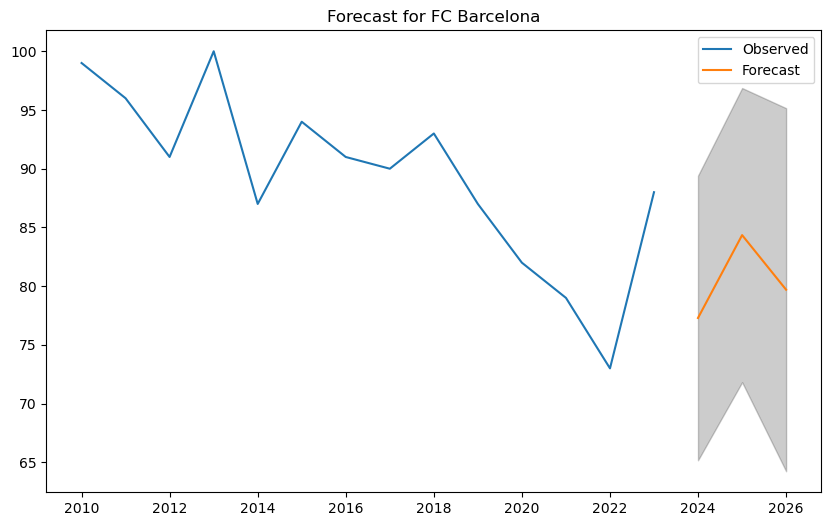

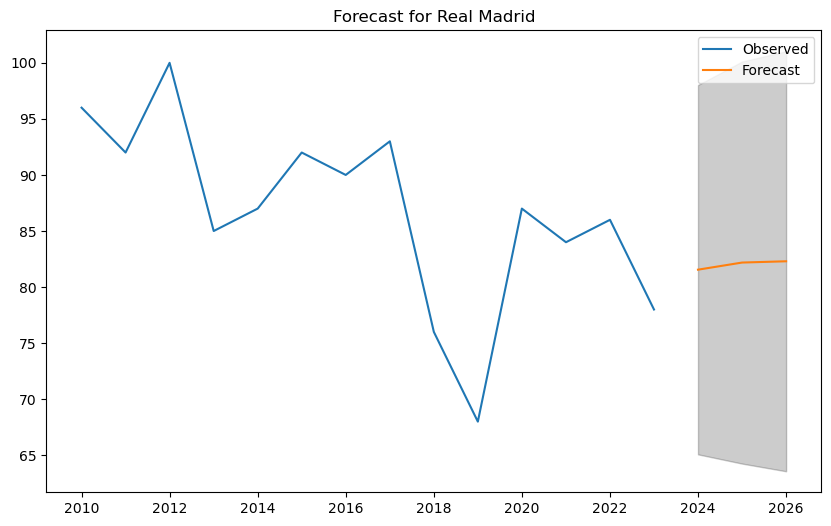

In [21]:
# Function to forecast points
def forecast_points(results, df, team_name):
    forecast = results.get_forecast(steps=3)
    forecast_ci = forecast.conf_int()
    
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['Points'], label='Observed')
    plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast')
    plt.fill_between(forecast_ci.index, 
                     forecast_ci.iloc[:, 0], 
                     forecast_ci.iloc[:, 1], color='k', alpha=.2)
    plt.title(f'Forecast for {team_name}')
    plt.legend()
    plt.show()
    
    return forecast.predicted_mean[-1]  # Return the final forecasted value for comparison

barca_forecast = forecast_points(barca_model, barca_df, "FC Barcelona")
real_madrid_forecast = forecast_points(real_madrid_model, real_madrid_df, "Real Madrid")

### Step 6: Compare Final Forecast Scores

In [24]:
# Compare the final forecast scores
print(f"Final Forecast Score for FC Barcelona: {barca_forecast}")
print(f"Final Forecast Score for Real Madrid: {real_madrid_forecast}")

if barca_forecast > real_madrid_forecast:
    print("FC Barcelona is predicted to perform better.")
else:
    print("Real Madrid is predicted to perform better.")

Final Forecast Score for FC Barcelona: 79.69639772978195
Final Forecast Score for Real Madrid: 82.30081026327997
Real Madrid is predicted to perform better.
